### Predictive Power of LMs

Reading the data and defining formulas

In [120]:
baseline_data <- read.csv("surprisal_data/baseline_surprisal_rts.csv")
bpe_data <- read.csv("surprisal_data/bpe_surprisal_rts.csv")
transducer_data <- read.csv("surprisal_data/transducer_surprisal_rts.csv")

In [121]:
control_formula <- 'rt ~ log_freq * word_length + prev_freq * prev_len'
surprisal_formula <- 'rt ~ surprisal + prev_surprisal + log_freq * word_length + prev_freq * prev_len'

Computing per-token $\Delta LogLik$ from models fit to entire dataset.

In [38]:
predictive_power <- function(data) {
    control_model <- glm(control_formula, data, family = 'gaussian')
    surprisal_model <- glm(surprisal_formula, data, family = 'gaussian')
    (logLik(surprisal_model) - logLik(control_model)) / nrow(data)
}

In [39]:
predictive_power(baseline_data)

'log Lik.' 0.01034982 (df=10)

In [40]:
predictive_power(bpe_data)

'log Lik.' 0.010752 (df=10)

In [41]:
predictive_power(transducer_data)

'log Lik.' 0.01025458 (df=10)

This is in line with the values from Wilcox et al (2020), but there does not seem to be a major difference between the models' predictive power. 

These metrics are reported for the entire dataset, so we now evaluate regression models against held-out data. For each model, we now report $\Delta LogLik$ for each run of 10-fold cross-validation.

In [135]:
test_data_loglik <- function(model, test_data) {
    predictions <- predict(model, test_data)
    stdev <- sigma(model)
    dnorm(test_data$rt, predictions, stdev, log = TRUE)
}

In [142]:
cross_validate <- function(data) {
    data<-data[sample(nrow(data)),]
    folds <- cut(seq(1,nrow(data)),breaks=10,labels=FALSE) # this is the same for each model
    predictive_power <- seq(1:10)
    for(i in 1:10){
        test_indices <- which(folds==i)
        test_data <- data[test_indices, ]
        train_data <- data[-test_indices, ]
        fold_control_model <- glm(control_formula, train_data, family = 'gaussian')
        fold_surprisal_model <- glm(surprisal_formula, train_data, family = 'gaussian')
        surprisal_diff <- test_data_loglik(fold_surprisal_model, test_data) - test_data_loglik(fold_control_model, test_data)
        predictive_power[i] <- mean(surprisal_diff) # summed per-token log likelihoods, divided by number of tokens 
        }
    predictive_power
}

In [144]:
library(ggplot2)
library(reshape2)

In [145]:
cv_results <- data.frame (
  baseline = cross_validate(baseline_data),
    bpe = cross_validate(bpe_data),
    transducer = cross_validate(transducer_data)
)

No id variables; using all as measure variables



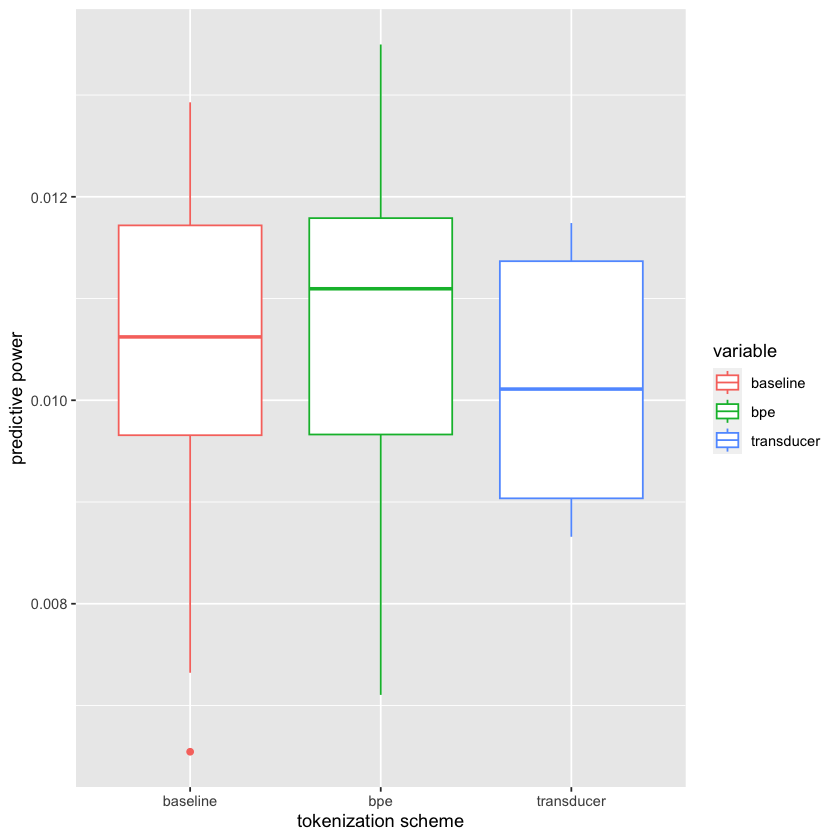

In [146]:
ggplot(melt(cv_results))+ geom_boxplot(aes(x = variable, y = value, color = variable)) + labs(y="predictive power",
                                                                            x = "tokenization scheme")

In [151]:
wilcox.test(cv_results$baseline, cv_results$bpe, paired = TRUE)


	Wilcoxon signed rank exact test

data:  cv_results$baseline and cv_results$bpe
V = 22, p-value = 0.625
alternative hypothesis: true location shift is not equal to 0


In [152]:
wilcox.test(cv_results$baseline, cv_results$transducer, paired = TRUE)


	Wilcoxon signed rank exact test

data:  cv_results$baseline and cv_results$transducer
V = 29, p-value = 0.9219
alternative hypothesis: true location shift is not equal to 0


### Slowdown in reading time due to surprisal 

Replicating the qualitative results from Wilcox et al (2020) on the relationship between surprisal and reading time. For each LM, we fit a generalized additive model and plot the slowdown in reading time due to surprisal. The plotting functionality with the `mgcViz` library was not compatible with other `ggplot`-based tools to make a figure with a grid.

In [47]:
library(mgcViz)

In [118]:
plot_gam <- function(data, color_index, plot_title) {
    rt_surprisal_gam <- gam(rt ~ s(surprisal, bs = "cr", k = 20) + s(prev_surprisal, bs = "cr", k = 20) 
            + te(log_freq, word_length, bs = "cr") + te(prev_freq, prev_len, bs = "cr"), data=data)
    # formula from pg 3 of https://arxiv.org/pdf/2006.01912.pdf (Wilcox et al 2020)
    plot(getViz(rt_surprisal_gam), select = 1, xlab = "surprisal", ylab = "slowdown") + l_fitLine(color = color_index) + l_ciLine(color = color_index) + 
    theme_get() + labs(x = "Surprisal", y = "Speedup in Reading Time (ms)", title = plot_title) + xlim(0, 25) + ylim(-20, 50)
}



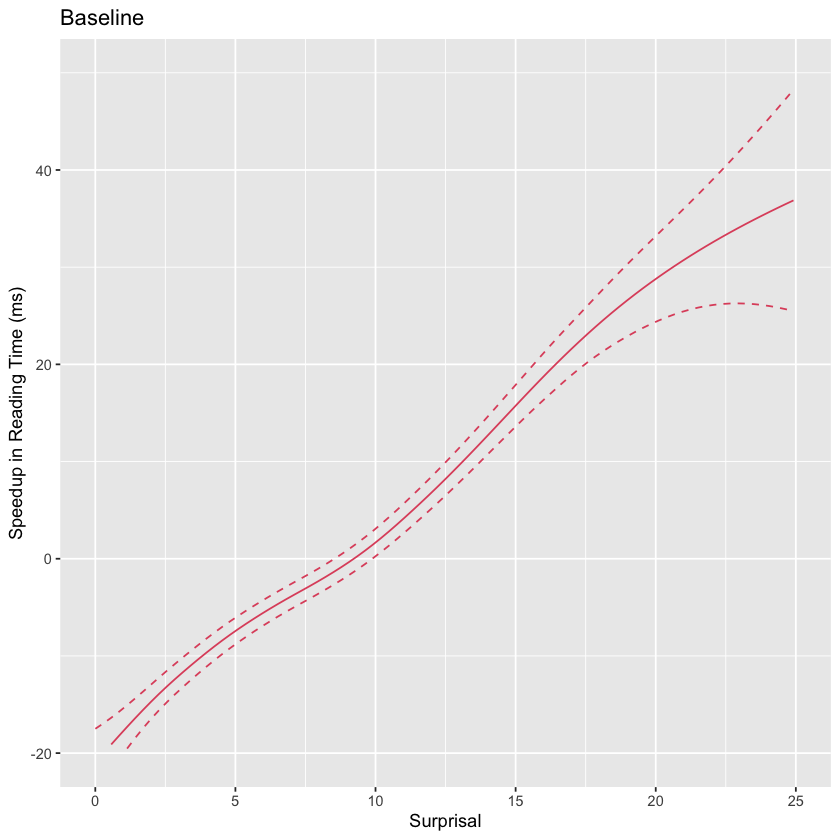

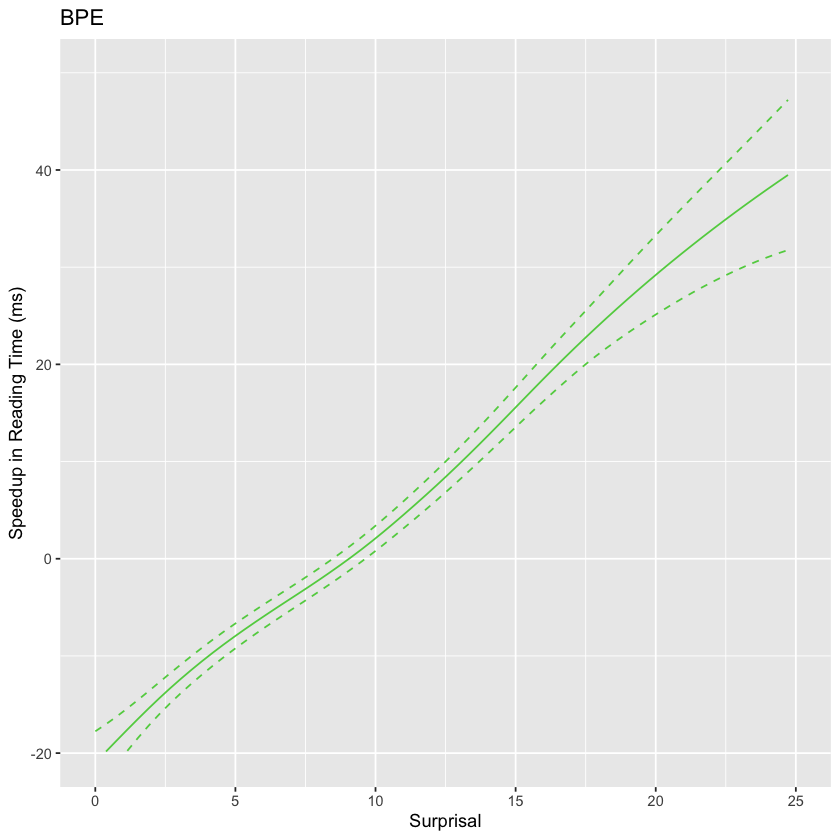

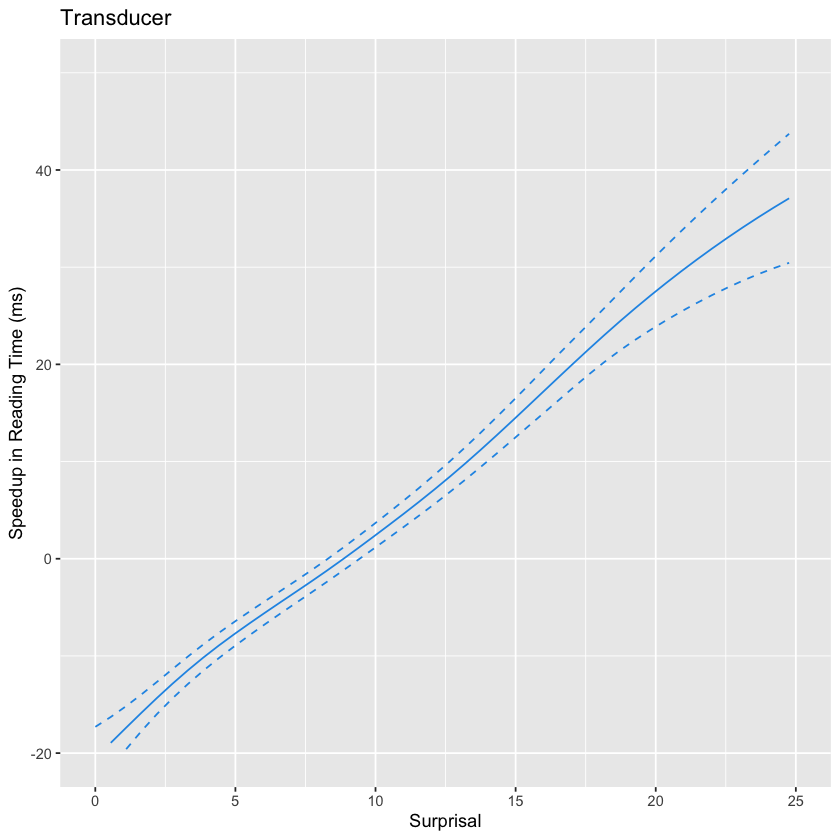

In [119]:
plot_gam(baseline_data, 2, "Baseline")
plot_gam(bpe_data, 3, "BPE")
plot_gam(transducer_data, 4, "Transducer")